In [1]:
from utils import harris, dist2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage 
from skimage.transform import warp
import numpy as np
# add your imports below
import cv2
from PIL import Image 

## 1. Load images and Convert to grayscale

In [2]:
img1 = Image.open('uttower_left.JPG').convert('L')
img1 = np.array(img1, dtype= np.float32)
img2 = Image.open('uttower_right.JPG').convert('L')
img2 = np.array(img2, dtype= np.float32)

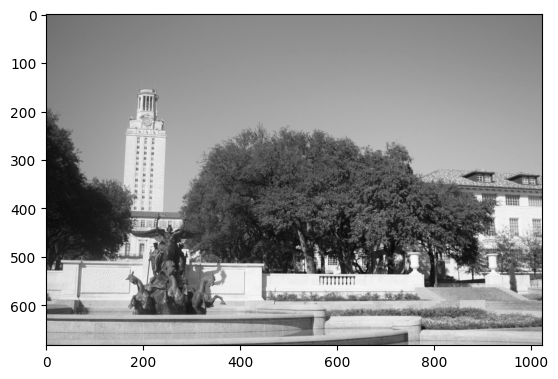

In [3]:
plt.imshow(img1, cmap='gray')

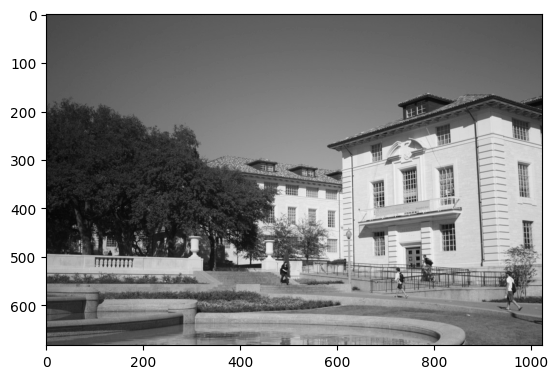

In [4]:
plt.imshow(img2, cmap='gray')

## 2. Detect Feature Points

In [5]:
# use harris from utils.py
cim1, r1, c1 = harris(img1, 3, 100, 3)
cim2, r2, c2 = harris(img2, 3, 100, 3)

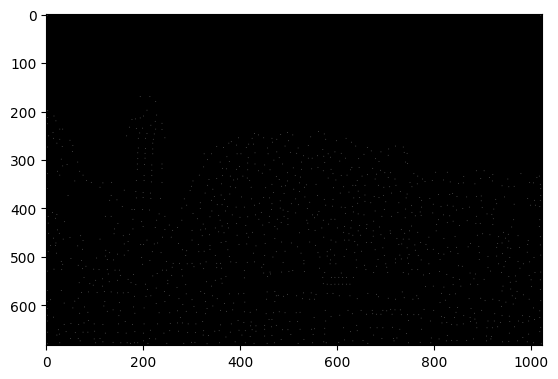

In [6]:
plt.imshow(cim1, cmap='gray')

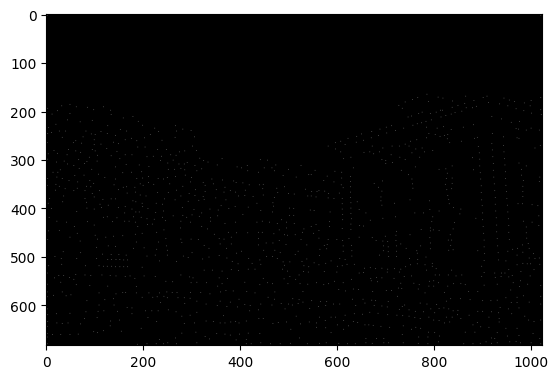

In [7]:
plt.imshow(cim2, cmap='gray')

In [8]:
def draw_corners(img, r, c):
    img_copy = img.copy()
    fig, ax = plt.subplots(figsize = (10, 10))
    for i in range(0, len(r)):
        rect = patches.Rectangle((c[i], r[i]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img_copy, cmap='gray')

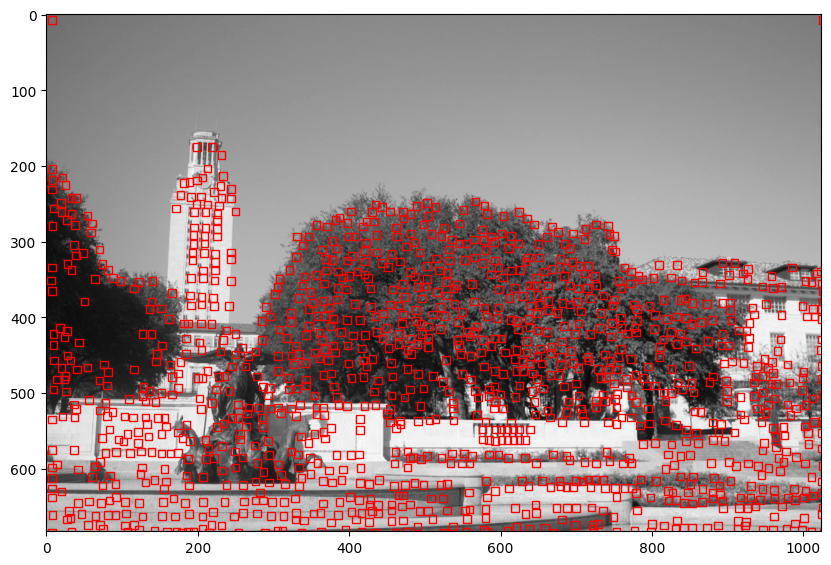

In [9]:
draw_corners(img1, r1, c1)

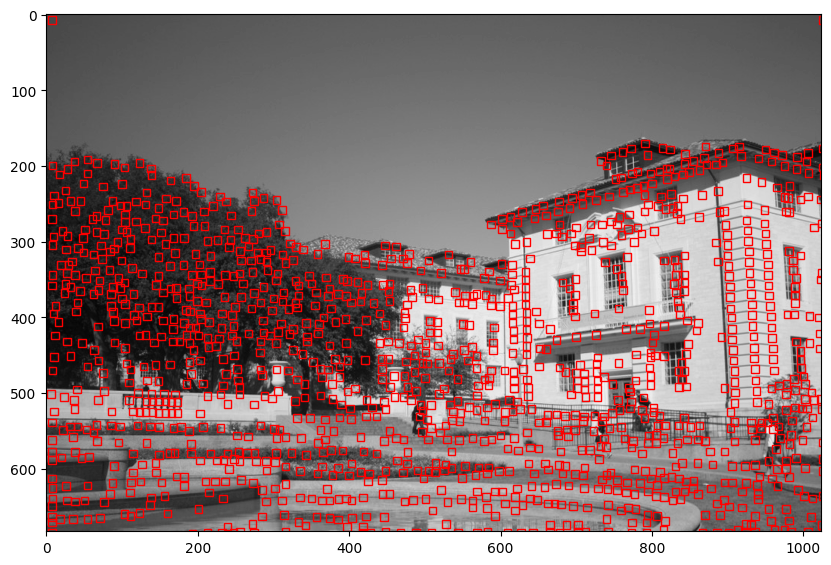

In [10]:
draw_corners(img2, r2, c2)

## 3. Extract local neighborhoods around every keypoint

In [11]:
def neighbor_descriptors(img, r, c, width):
    descriptors = []
    radius = width // 2
    for i in range(len(r)):
        rowStart = r[i] - radius
        rowEnd = r[i] + radius + 1
        colStart = c[i] - radius
        colEnd = c[i] + radius + 1

        patch = img[rowStart:rowEnd, colStart:colEnd]
        flatennedPatch = patch.reshape(-1)

        descriptors.append(flatennedPatch)

    descriptors = np.array(descriptors)

    return descriptors

radius = 1
width = 2 * radius + 1

descriptors1 = neighbor_descriptors(img1, r1, c1, width)
print(descriptors1.shape)
descriptors2 = neighbor_descriptors(img2, r2, c2, width)
print(descriptors2.shape)



(1201, 9)
(1309, 9)


## 4. Compute distances between descriptors

In [12]:
# use dist2 from utils.py to compute dist between descriptors
distances = dist2(descriptors1, descriptors2)
print(distances)
print(distances.shape)



[[ 13770.  23005. 140976. ...  92988. 112260.  71871.]
 [  9094.  16817. 125676. ...  80050.  98060.  60887.]
 [  7152.   9933.  84870. ...  50160.  61660.  40951.]
 ...
 [  1553.   4242.  90321. ...  45307.  61655.  28762.]
 [  6616.  13333. 115574. ...  72142.  89114.  54443.]
 [  1170.   1535.  62292. ...  31506.  42476.  23747.]]
(1309, 1201)


## 5. Select Matches

In [13]:
threshold = 0.5

num_matches = 100
sorted_indices = np.argsort(distances, axis=None)
putative_matches = np.unravel_index(sorted_indices[:num_matches], distances.shape)


print("Number of putative matches:", len(putative_matches[0]))
print("Selected pairs:")
for i in range(len(putative_matches[0])):
    idx1 = putative_matches[0][i]
    idx2 = putative_matches[1][i]
    print("Descriptor 1:", idx1, "Descriptor 2:", idx2)

Number of putative matches: 100
Selected pairs:
Descriptor 1: 990 Descriptor 2: 1136
Descriptor 1: 1150 Descriptor 2: 1178
Descriptor 1: 1208 Descriptor 2: 964
Descriptor 1: 567 Descriptor 2: 1137
Descriptor 1: 1152 Descriptor 2: 1193
Descriptor 1: 990 Descriptor 2: 870
Descriptor 1: 475 Descriptor 2: 148
Descriptor 1: 1045 Descriptor 2: 1134
Descriptor 1: 836 Descriptor 2: 998
Descriptor 1: 1150 Descriptor 2: 1177
Descriptor 1: 1229 Descriptor 2: 960
Descriptor 1: 161 Descriptor 2: 968
Descriptor 1: 1150 Descriptor 2: 1193
Descriptor 1: 1036 Descriptor 2: 925
Descriptor 1: 1279 Descriptor 2: 1124
Descriptor 1: 1152 Descriptor 2: 1000
Descriptor 1: 990 Descriptor 2: 998
Descriptor 1: 812 Descriptor 2: 951
Descriptor 1: 764 Descriptor 2: 174
Descriptor 1: 552 Descriptor 2: 1188
Descriptor 1: 1241 Descriptor 2: 813
Descriptor 1: 629 Descriptor 2: 458
Descriptor 1: 154 Descriptor 2: 554
Descriptor 1: 1134 Descriptor 2: 1
Descriptor 1: 287 Descriptor 2: 1122
Descriptor 1: 347 Descriptor 2:

## 6. RANSAC

Number of inliers: 102
Average residual:  3753330.1960784313


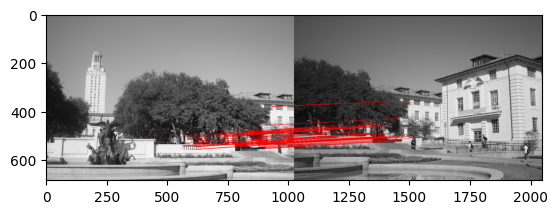

In [14]:
img1 = Image.open('uttower_left.JPG')
img1 = np.array(img1.convert('L'), dtype=np.uint8)
img2 = Image.open('uttower_right.JPG')
img2 = np.array(img2.convert('L'), dtype=np.uint8)

orb = cv2.ORB_create()


kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)


index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=2)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])

pts1 = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

num_iterations = 1000
num_samples = 4
inlier_threshold = 5.0

best_num_inliers = 0
best_model = None

for i in range(num_iterations):
    random_indices = np.random.choice(len(good_matches), num_samples, replace=False)
    src_points = pts1[random_indices]
    dst_points = pts2[random_indices]

    
    model, _ = cv2.findHomography(src_points, dst_points)

    
    transformed_pts = cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), model)
    distances = np.linalg.norm(transformed_pts.squeeze() - pts2, axis=1)

    
    num_inliers = np.sum(distances < inlier_threshold)


    if num_inliers > best_num_inliers:
        best_num_inliers = num_inliers
        best_model = model

print('Number of inliers: %d' % best_num_inliers)


residual = np.sum((pts2 - cv2.perspectiveTransform(pts1.reshape(-1, 1, 2), best_model))**2) / best_num_inliers
print('Average residual: ', residual)


def draw_matches(img1, img2, kp1, kp2, matches, color=None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1 + w2] = img2
    vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
    if color is None:
        color = (255, 0, 0)

    for m in matches:
        end1 = tuple(np.round(kp1[m[0].queryIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m[0].trainIdx].pt).astype(int) + np.array([w1, 0]))
        cv2.line(vis, end1, end2, color)

    return vis

# display the locations of inlier matches in both images
inlier_match_img = draw_matches(img1, img2, kp1, kp2, good_matches, color=None)
plt.imshow(inlier_match_img)
plt.show()


## 7. Warp one image onto the other

In [15]:
def warp_img(image_left, image_right, H):

    image_left = image_left.astype(np.uint8)
    image_right = image_right.astype(np.uint8)
    # this part of code is referenced from Ajinkya Tejankar
    # get the height and width of the image
    # this function will work with color images
    # so, having third color channel is not a problem
    h = max(image_right.shape[0] , image_left.shape[0])
    w = image_left.shape[1] + image_right.shape[1] - 500

    # # we want to find where the image corners are going to land
    # # so, we create a matrix of four corner points
    # C_left = np.array([
    #     [0, 0     , w, w],
    #     [0, h, 0     , h],
    #     [1, 1     , 1     , 1     ]
    # ])

    # # apply the homography to the corner points to get projected corner points
    # Cp_left = H @ C_left
    # Cp_left = Cp_left / Cp_left[-1, :]

    # # find the minimum height and width of the projected corners
    # w_min, h_min = Cp_left[:-1].min(axis=1).tolist()
    # # we might need to properly floor or ceil the floats to prevent
    # # the edge pixels from getting cropped but this works for our needs
    # # feel free to fix this
    # w_min, h_min = int(np.abs(w_min)), int(np.abs(h_min))
    # # what's the final warped image size that can hold the full image?
    # warped_image_shape = (h + h_min, w + w_min)

    # # we create a new homography that applies the translation
    # # that would be otherwise cropped by the warp function below
    # Ht = np.array([
    #     [1, 0, w_min],
    #     [0, 1, h_min],
    #     [0, 0, 1    ]
    # ])
    # # apply the translation homography so that the image is warped
    # # but does not have a negative translation relative to origin
    # Hw = Ht @ H
    # # may not be strictly necessary but make sure that (3,3) is 1
    # Hw = Hw / Hw[-1, -1]

    # use skimage.transform.ProjectiveTransform to create a transform for the homography Hw
    tform = skimage.transform.ProjectiveTransform(H)
    warped_image_right = (warp(image_right, tform, output_shape=(h, w)) * 255).astype('float32')

    # use skimage.transform.warp to apply the transform
    warped_image = np.zeros((h, w), dtype='float32')

    warped_image[:, :image_left.shape[1]] = image_left

    return np.where(warped_image_right != 0, warped_image_right, warped_image)


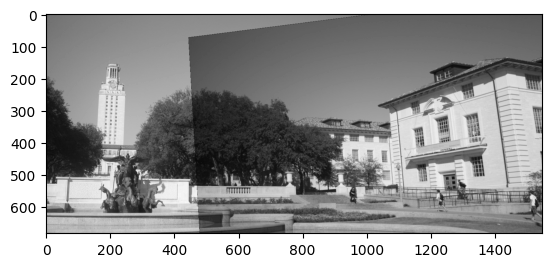

In [16]:
warped_img1 = warp_img(img1, img2, best_model)
plt.imshow(warped_img1, cmap='gray')

## 8. Create a new image to hold the panorama

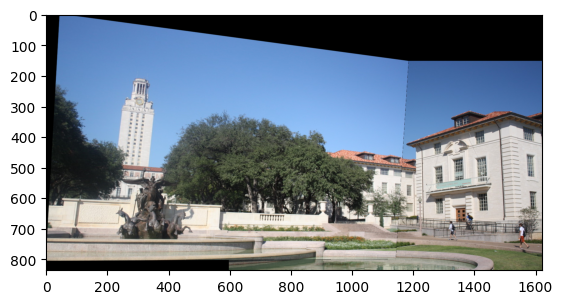

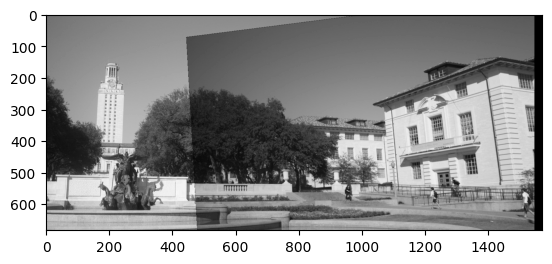

In [17]:
def create_panorama(warped_img1, img2):
    h = img2.shape[0]
    w = img2.shape[1] + warped_img1.shape[1] - 1000

    panorama = np.zeros((h, w), dtype=np.float32)

    panorama[:warped_img1.shape[0], :warped_img1.shape[1]] = warped_img1

    overlap_width = img2.shape[1] - (warped_img1.shape[1] - 500)
    for y in range(h):
        for x in range(warped_img1.shape[1] - 500, min(w, img2.shape[1])):
            alpha = (x - (warped_img1.shape[1] - 500)) / overlap_width
            panorama[y, x] = (1 - alpha) * warped_img1[y, x - (warped_img1.shape[1] - 500)] + alpha * img2[y, x]

    return panorama



def create_panorama_rgb(img1, img2, H):
    corners = np.array([[0, 0, img1.shape[1], img1.shape[1]], 
                        [0, img1.shape[0], 0, img1.shape[0]], 
                        [1, 1, 1, 1]])
    corners_transformed = np.dot(H, corners)
    corners_transformed = corners_transformed / corners_transformed[2, :]
    min_x, min_y = np.intp(corners_transformed[:2, :].min(axis=1))
    max_x, max_y = np.intp(corners_transformed[:2, :].max(axis=1))
    
    w = max(max_x, img2.shape[1]) - min(min_x, 0)
    h = max(max_y, img2.shape[0]) - min(min_y, 0)

    T = np.array([[1, 0, -min_x], 
                  [0, 1, -min_y], 
                  [0, 0, 1]], dtype=np.float32)

    H = np.dot(T, H)

    panorama = np.zeros((h, w, 3), dtype=np.uint8)

    for channel in range(3):

        warped_channel = cv2.warpPerspective(img1[:, :, channel], H, (w, h))
        panorama[:, :, channel] = np.where(panorama[:, :, channel]==0, warped_channel, panorama[:, :, channel])

 
        T_img2 = T
        warped_img2 = cv2.warpPerspective(img2[:, :, channel], T_img2, (w, h))
        panorama[:, :, channel] = np.where(panorama[:, :, channel]==0, warped_img2, panorama[:, :, channel])

    return panorama


img1_color = cv2.imread('uttower_left.JPG')
img2_color = cv2.imread('uttower_right.JPG')


panorama = create_panorama_rgb(img1_color, img2_color, best_model)
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

warped_img2 = warp_img(img2, img1, best_model)

panorama1 = create_panorama(warped_img1, img2)
plt.imshow(panorama1, cmap='gray')
plt.show()

